In [1]:
'''
## © Copyright (C) 2020-2024 Xilinx, Inc
##
## Licensed under the Apache License, Version 2.0 (the "License"). You may
## not use this file except in compliance with the License. A copy of the
## License is located at
##
##     http://www.apache.org/licenses/LICENSE-2.0
##
## Unless required by applicable law or agreed to in writing, software
## distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
## WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
## License for the specific language governing permissions and limitations
## under the License.
##
## Developed by SplineAI (www.spline.ai) in Collaboration with Xilinx
'''

# USAGE
# python train_pne.py --network Pnem1      --weights keras_model/Pneumonia/Pnem1      --epochs  20 --init_lr 0.01 --batch_size 32
# python train_pne.py --network Pnem2 --weights keras_model/Pneumonia/Pnem2 --epochs  40 --init_lr 0.01 --batch_size 64
# python train_pne.py --network Pnem3 --weights keras_model/Pneumonia/Pnem3 --epochs 100 --init_lr 0.1  --batch_size 128


# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

#from custom_cnn import ConvNetFactory

# import the necessary packages
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import backend as K
#import tensorflow.keras as K
#from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv2

from datetime import datetime #DB
from keras.utils import plot_model #DB
from keras.callbacks import ModelCheckpoint #DB
from keras.callbacks import LearningRateScheduler
import os # DB

from random import seed
from random import random
from random import shuffle #DB

import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

from keras.models import Model,load_model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing import image  
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight 
from keras import regularizers
from keras.regularizers import l1
from keras.applications.inception_v3 import InceptionV3 
from keras import backend as K

# Setting seeds for reproducibility
seed = 232
#from tensorflow.compat.v1 import ConfigProto,InteractiveSession
#np.random.seed(seed)
#tf.set_random_seed(seed)

Using TensorFlow backend.


In [2]:
###################################################################################################################
#input_path = '../dataset/Pneumonia/covid_data/'
input_path = './data/' 

mpath1 = './Pneumonia/Pnem1/'
fmod1 = os.path.sep.join([mpath1, "best_chkpt.hdf5"]) 
mpath2 = './Pneumonia/Pnem2/'
fmod2 = os.path.sep.join([mpath2, "best_chkpt.hdf5"]) 
mpath3 = './Pneumonia/Pnem3/'
fmod3 = os.path.sep.join([mpath3, "best_chkpt.hdf5"]) 
mpath4 = './Pneumonia/Pnem4/'
fmod4 = os.path.sep.join([mpath4, "best_chkpt.hdf5"]) 

In [3]:
network='Pnem2'
img_dims=224 
fweights = './Pneumonia/' + network 
fname = os.path.sep.join([fweights, "best_chkpt.hdf5"])
print(fname)

./Pneumonia/Pnem2/best_chkpt.hdf5


In [4]:
def process_data(img_dims):
    #Data generation objects
    n_normal = 0 
    n_pneumonia = 0
    x_test = list()
    y_test = list()
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + cond)):
            impath = input_path+cond+img 
            imga = cv2.imread(impath) #, cv2.COLOR_BGR2GRAY)
            imga = cv2.resize(imga, (img_dims, img_dims)) 
            imga = np.dstack([imga])
            if cond=='/NORMAL/':
                label = 0
                n_normal = n_normal + 1
            else: 
                label = 1 
                n_pneumonia = n_pneumonia + 1
            x_test.append(imga)
            y_test.append(label) 

    len_xtest = len(x_test)
    print("INFO: test #(NORMAL, PNEUMONIA) = ({}, {})".format(n_normal, n_pneumonia))
    
    x_test  = np.asarray(x_test)/255.0 
    y_test = to_categorical(y_test, 2)
    
    return x_test, y_test, len_xtest

In [5]:
# Getting the data
x_test, y_test, len_xtest = process_data(img_dims)

INFO: test #(NORMAL, PNEUMONIA) = (886, 602)


In [6]:
 def model_Pnem2(img_dims):
    inputs = Input(shape=(img_dims, img_dims, 3))

    # Ist conv block
    x = Conv2D(filters=64, kernel_size=(4, 4), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(inputs)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x)
    x = Activation('relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)

    # 2nd conv block
    x = Conv2D(filters=128, kernel_size=(4, 4), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(4, 4), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x) 
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    # 3rd conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x) 
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    # Fourth conv block
    x = Conv2D(filters=384, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=384, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    # fifth conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x) 
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    # sixth conv block
    x = Conv2D(filters=1024, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1024, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x) 
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=2048, activation='relu')(x)
    x = Dropout(rate=0.4)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.2)(x) 
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(rate=0.2)(x) 
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.1)(x)
    # Output layer 
    output = Dense(units=2, activation='softmax', name='dense_out')(x)

    # Creating model and compiling
    model = Model(inputs=inputs, outputs=output) 
    model.summary()
    return model

model = model_Pnem2(img_dims)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      3136      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      65600     
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 64)      0        

In [7]:
#model = load_model(fname)
model.load_weights(fname) 

In [8]:
def get_last_conv_layer_info(model):
    last_conv_layer_name="conv2d" 
    last_conv_filter = 0
    for ml in model.layers:
        #print ("{}, {} {}".format(ml.name, ml.output.get_shape(), ml.output.get_shape()[-1] ))
        if "conv2d_" in ml.name:
            last_conv_layer_name = ml.name
            last_conv_filter = ml.output.get_shape()[-1]
    return last_conv_layer_name, last_conv_filter

last_conv_layer_name, last_conv_filter = get_last_conv_layer_info(model)
LAST_CONV_NAME=last_conv_layer_name
LAST_CONV_SIZE=last_conv_filter 
if LAST_CONV_SIZE < 1:
    print("ERROR: Last Covlution information not found. No heatmap will be generated")
else:
    print("Last Conv layer = ({}, {})".format(LAST_CONV_NAME, LAST_CONV_SIZE))

Last Conv layer = (conv2d_12, 1024)


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix
preds = model.predict(x_test)

print(classification_report(y_test, preds.round(), target_names=['NORMAL', 'PNEUMONIA'])) 
#print(classification_report(y_test, preds.round()))

              precision    recall  f1-score   support

      NORMAL       0.94      0.98      0.96       886
   PNEUMONIA       0.97      0.90      0.93       602

   micro avg       0.95      0.95      0.95      1488
   macro avg       0.95      0.94      0.95      1488
weighted avg       0.95      0.95      0.95      1488
 samples avg       0.95      0.95      0.95      1488



In [10]:
output1 = []
out_test = []
for i in range(len(preds)):
    output1.append(list(preds[i]).index(max(preds[i])))
for i in range(len(y_test)):
    out_test.append(list(y_test[i]).index(max(y_test[i])))

#print(list(np.round(output1)).count(0)/len(output1))
#print(list(out_test).count(0)/len(out_test))

In [11]:
acc = accuracy_score(out_test, output1)*100
print(acc)

94.89247311827957


In [12]:
cm = confusion_matrix(out_test, output1)
#tn, fp, fn, tp = cm.ravel()
print('CONFUSION MATRIX ------------------')
print(cm)

CONFUSION MATRIX ------------------
[[869  17]
 [ 59 543]]


In [13]:
import seaborn as sn
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
df_cm = pd.DataFrame(cm, index = [i for i in ["NORMAL","PNUMONIA"]],
                  columns = [i for i in ["NORMAL","PNUMONIA"]])
plt.figure(figsize = (12,8)) 
sn.set(font_scale=1.2) # for label size 

<Figure size 864x576 with 0 Axes>

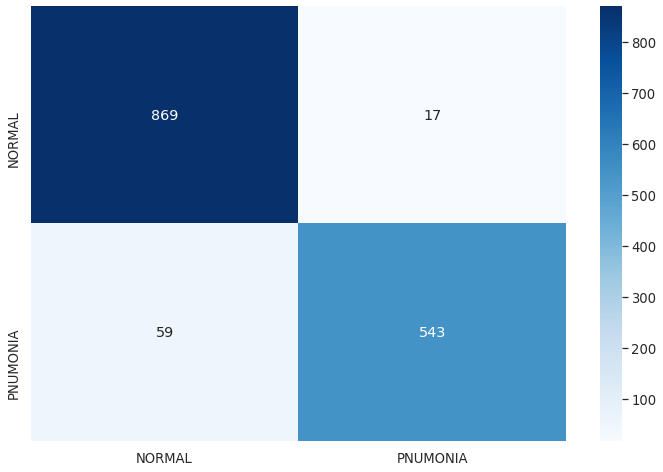

In [14]:
sn.set(font_scale=1.2) # for label size
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True,fmt="d", cmap = "Blues")

In [15]:
labels = {0:"NORMAL",1:"PNEUMONIA"} 

In [16]:
from skimage import data, color, io, img_as_float
from skimage import filters
def get_heatmap(processed_image, class_idx):
    # we want the activations for the predicted label
    class_output = model.output[:, class_idx]
    
    # choose the last conv layer in your model
    last_conv_layer = model.get_layer(LAST_CONV_NAME)   
    # get the gradients wrt to the last conv layer
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    #print(grads)
    # we pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = K.mean(grads, axis=(0,1,2))
    #print(pooled_grads)
    # Define a function that generates the values for the output and gradients
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = iterate([processed_image])
    # print("Grad Values shape {}".format(grads_values.shape))
    # iterate over each feature map in your conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    ncov = grads_values.shape[0] #1024
    for i in range(ncov): # we have 1024 features in our last conv layer
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

In [17]:
def mlpredict(raw_image, model):
    image = cv2.imread(raw_image) 
    image = cv2.resize(image, (img_dims,img_dims))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    norm_image = image.astype(np.float32)/255. 
    image_processed = np.expand_dims(norm_image, axis=0) 
    label = np.argmax(model.predict(image_processed), axis=-1)[0] 
    pred_label = labels[label]
    #print("Prediction#: {}".format(pred_label))
    return label, pred_label, norm_image, image_processed

In [18]:
def heatm(pred_label, norm_image, image_processed):
    # get the heatmap for class activation map(CAM)
    heatmap = get_heatmap(image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (norm_image.shape[0], norm_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    #superimpose the heatmap on the image    

    sample_image_hsv = color.rgb2hsv(norm_image)
    heatmap = color.rgb2hsv(heatmap)

    alpha=.9
    sample_image_hsv[..., 0] = heatmap[..., 0]
    sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

    img_masked = color.hsv2rgb(sample_image_hsv)
    return img_masked

In [19]:
def plot(image, original_label, pred_label, heatmap):  
    f,ax = plt.subplots(1,2, figsize=(16,16))
    ax = ax.ravel()
    ax[0].imshow(image)
    ax[0].set_title(f"Orignal label : {original_label}\n  Predicted label: {pred_label}")
    ax[0].axis('off')
    
    cv2.putText(heatmap,pred_label, (60,115), cv2.FONT_HERSHEY_SIMPLEX,.25, (0,0,0), 1)
    ax[1].imshow(heatmap)
    ax[1].set_title("Class Activation Map")
    ax[1].axis('off')
    plt.show()

In [20]:
def final(img, original_label): 
    label_index, pred_label, norm_image, image_processed = mlpredict(img, model)  
    heatmap_masked = heatm(label_index, norm_image, image_processed)
    plot(norm_image, original_label, pred_label, heatmap_masked)

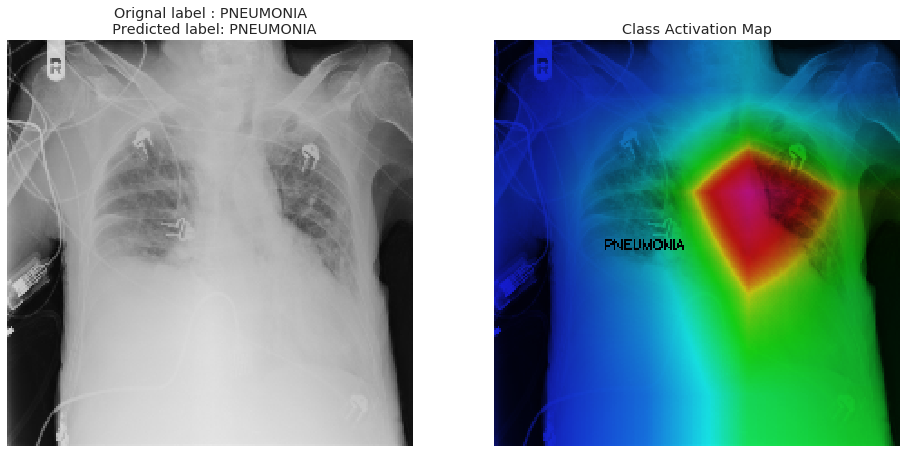

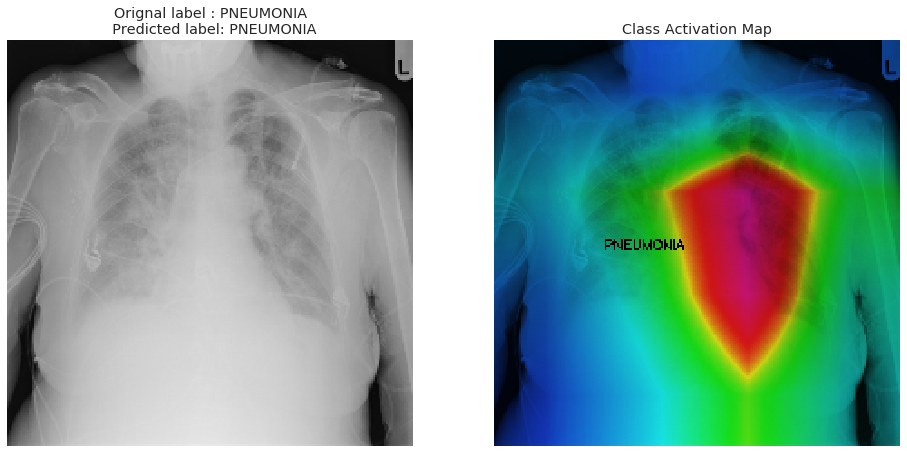

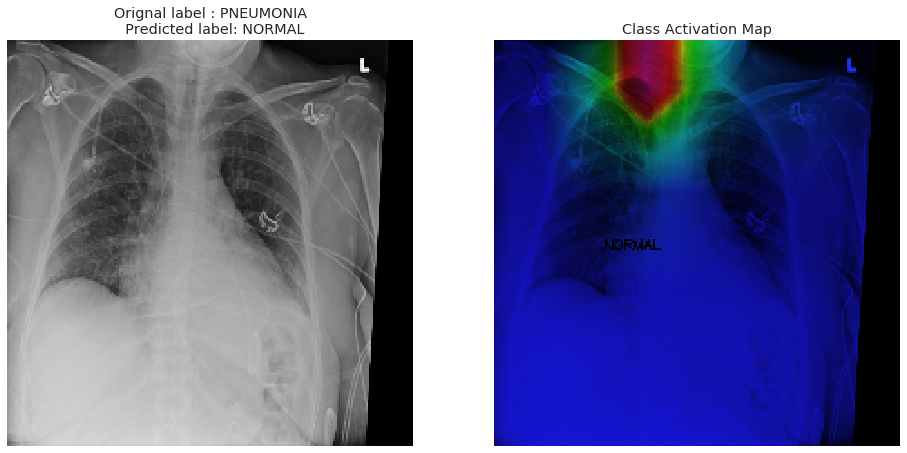

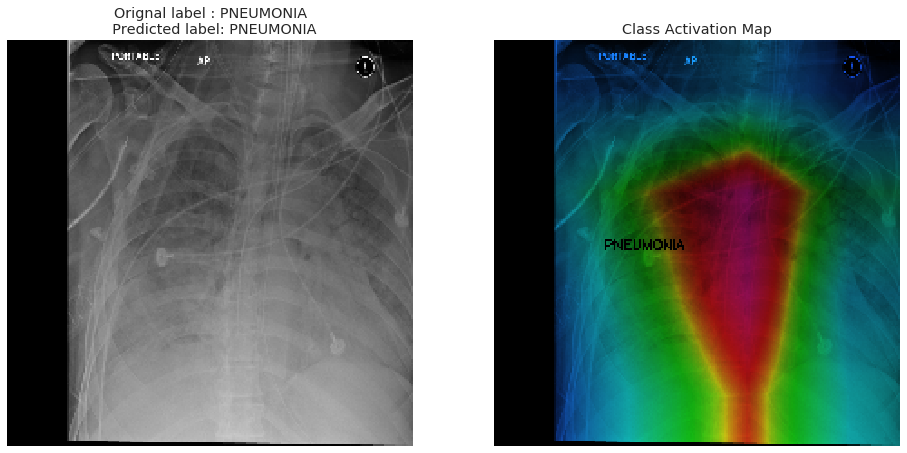

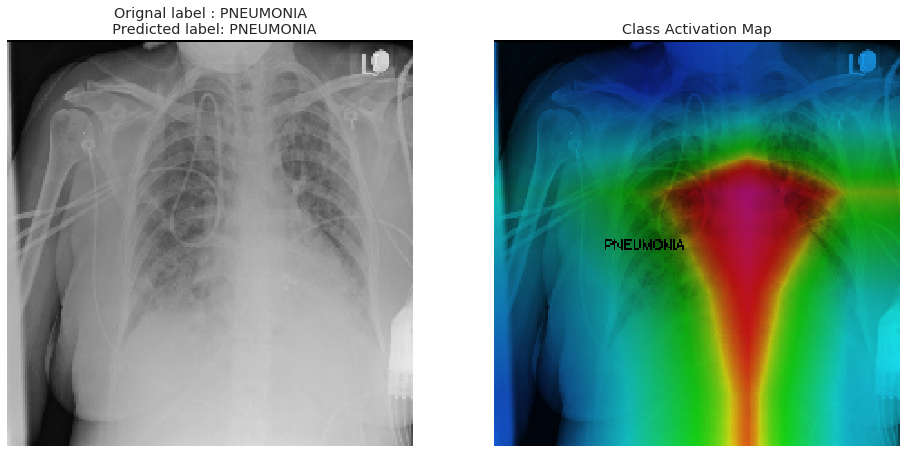

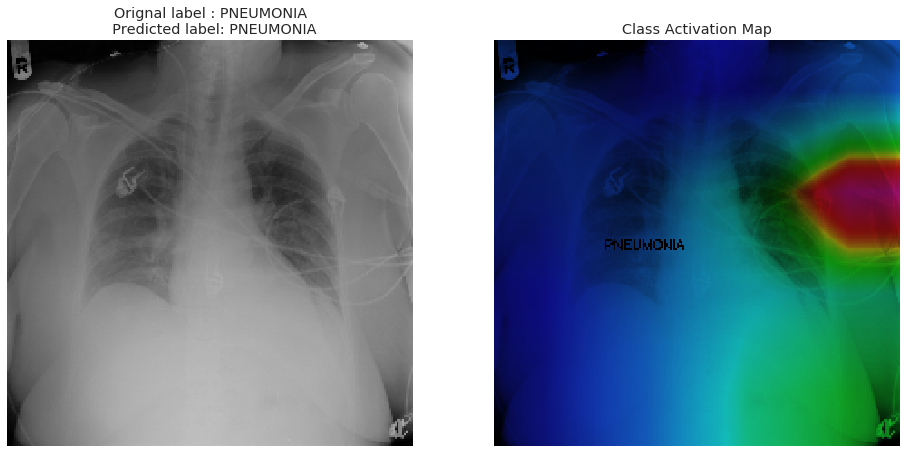

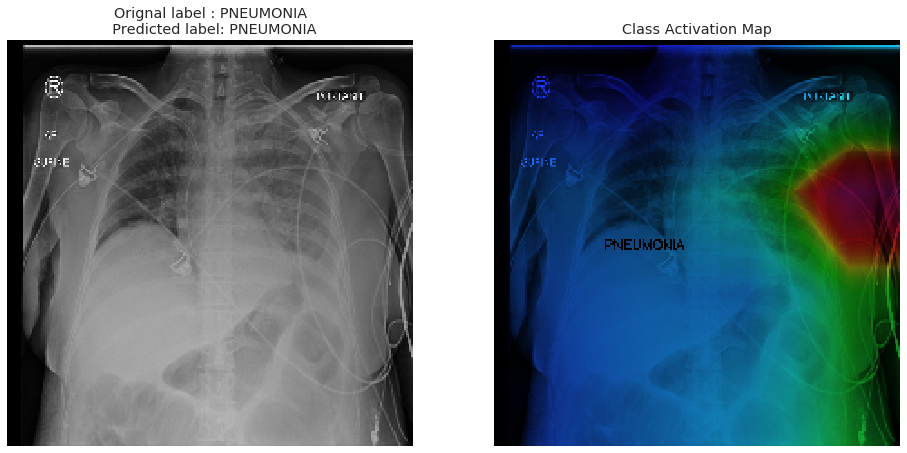

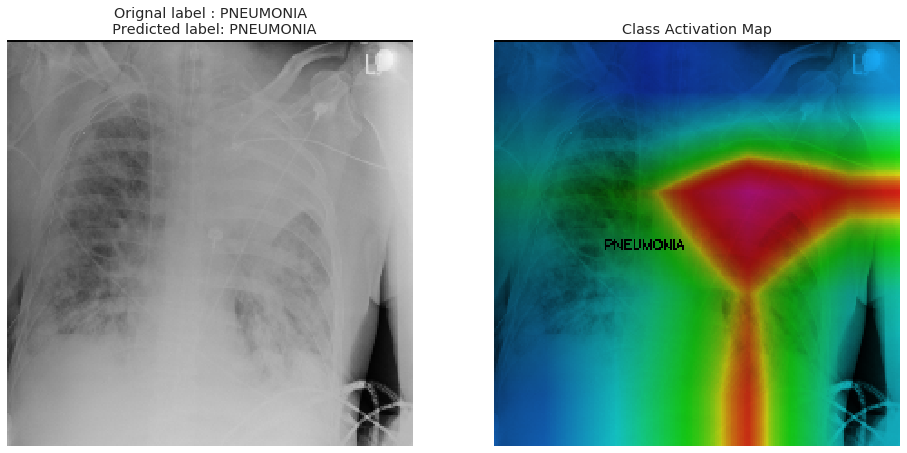

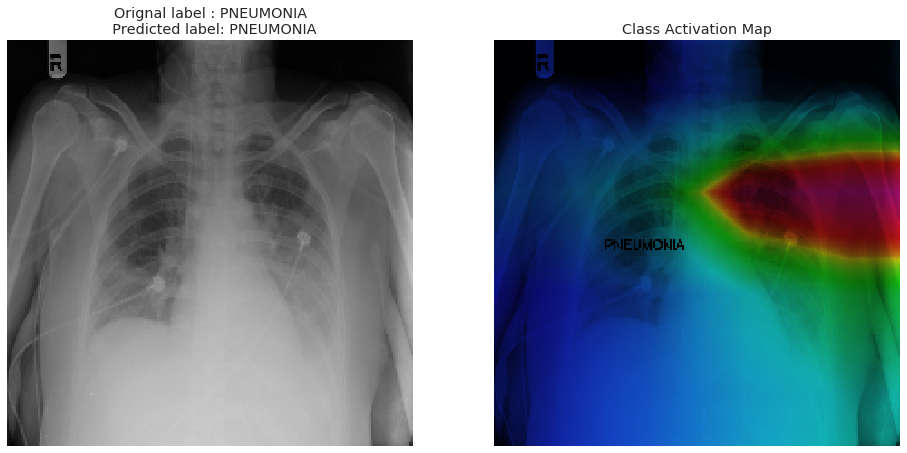

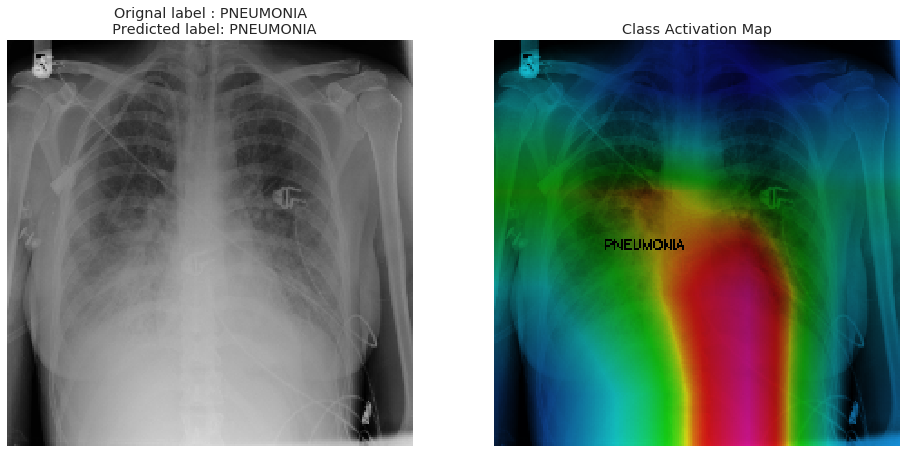

In [21]:
from glob import glob #retriving an array of files in directories
import random
random.seed(42)
img = glob(input_path + "/PNEUMONIA/*") 
ilen = len(img) 
todisplay=10  
#start = random.randint(0, ilen-todisplay-1)  #Display Heatmap for randomly selected 10 images
start=0
img=img[start:start+todisplay]
with np.errstate(divide='ignore'):  #Ignore repeated warning on potential devide by 0
    for i in img[:]: 
        final(i, 'PNEUMONIA')